In [6]:
from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_service_pb2_grpc
import grpc

# 向TensorFlow Serving服务请求预测结果。
def request_server(img, server_url):
    # 为服务器创建一个通道
    channel = grpc.insecure_channel(server_url)
    # 在客户端中实现stub，利用这个stub可以调用相应的服务器中的服务
    stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)
    # 定义请求
    request = predict_pb2.PredictRequest()
    # 设置模型名称，需要跟启动tf-serving服务器时模型的名字一样
    request.model_spec.name = "my_model"  
    # 模型签名，可以使用saved_model_cli命令查看
    request.model_spec.signature_name = "serving_default" 
    # 模型输入名称为"image_input"，之前模型保存的时候设置为"image"后面的"_input"是程序自动加上的
    # 设置要传输的数据img，数据的格式tf.float32，数据的形状img.shape
    request.inputs["image_input"].CopyFrom(tf.make_tensor_proto(img, dtype=tf.float32, shape=img.shape))
    # 传数据获得预测结果，最多等待5秒
    response = stub.Predict(request, 5.0)  
    # output为模型输出名称，之前模型保存的时候设置的，变成array后返回
    return np.asarray(response.outputs["output"].float_val) 

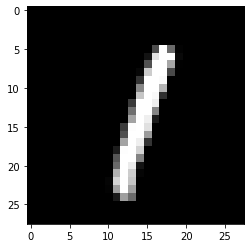

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# 载入数据集
mnist = tf.keras.datasets.mnist
# 载入数据，数据载入的时候就已经划分好训练集和测试集
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# 对训练集和测试集的数据进行归一化处理
x_train, x_test = x_train / 255.0, x_test / 255.0
# x_test中第5张图片标签为1
plt.imshow(x_test[5],cmap='gray')
# 显示图片
plt.show()

In [8]:
# grpc地址及端口，启动tf-serving服务器程序的时候有看到过
server_url = '0.0.0.0:8500'
# 预测一个数据
pre = request_server(x_test[5], server_url)
print("预测结果为：",np.argmax(pre))

预测结果为： 1


In [9]:
# 预测一个批次的数据，比如一次性预测16个数据
num = 16
# 获得预测结果
pre = request_server(x_test[:num], server_url)
# reshape变成16行10列
pre = pre.reshape((num,10))
print("预测结果为：",np.argmax(pre,axis=1))
print("真实标签为：",y_test[:num])

预测结果为： [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5]
真实标签为： [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5]
